<a href="https://colab.research.google.com/github/EladBenjo/Data-Science-Workshop-2025a/blob/main/fed_speeches_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro: packages import, data collection and framing.

##Import the packages we are using

In [ ]:
pip install wordcloud fredapi yfinance

In [ ]:
import sqlite3
import requests
import time
from datetime import datetime
import logging
from google.colab import drive
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
import yfinance as yf
from fredapi import Fred


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## import speeches data

For our database, we scraped speeches spanning 1996–2025 from the "Federal Reserve Board of Governors" website. While our analysis will primarily focus on the speech text, we will begin by examining the other columns, cleaning and preparing them to provide additional context and insights.

In [ ]:
# Connect to the SQL database
db_path = '/content/drive/MyDrive/Colab Notebooks/fed_speeches_1996_2025.db'
conn = sqlite3.connect(db_path)

# Load the table into a DataFrame
query = "SELECT * FROM speeches;"
df = pd.read_sql_query(query, conn)

# Display basic information about the dataset
print("Dataset Overview:")
print(df.info())

# Display a sample of the dataset
print("\nSample Data:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1796 non-null   int64 
 1   speech_date  1796 non-null   object
 2   title        1796 non-null   object
 3   speaker      1796 non-null   object
 4   event        1796 non-null   object
 5   link         1796 non-null   object
 6   speech_text  1792 non-null   object
 7   scrape_date  1796 non-null   object
 8   processed    1796 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 126.4+ KB
None

Sample Data:
   id speech_date                                              title  \
0   1  1996-12-19                    Supervision of bank risk-taking   
1   2  1996-12-06                                    Social security   
2   3  1996-12-05  The challenge of central banking in a democrat...   
3   4  1996-12-03                 Clearinghouses and risk manageme

In [ ]:
df

,id,speech_date,title,speaker,event,link,speech_text,scrape_date,processed
0,1,1996-12-19,Supervision of bank risk-taking,Vice Chair Alice M. Rivlin,At the The Brookings Institution National Issu...,https://www.federalreserve.gov/boarddocs/speec...,I discovered when I joined the Board of Govern...,2025-01-06,1
1,2,1996-12-06,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,https://www.federalreserve.gov/boarddocs/speec...,I am privileged to accept the Union League of ...,2025-01-06,1
2,3,1996-12-05,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,https://www.federalreserve.gov/boarddocs/speec...,The Challenge of Central Banking in a Democrat...,2025-01-06,1
3,4,1996-12-03,Clearinghouses and risk management,"Governor Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...",https://www.federalreserve.gov/boarddocs/speec...,"Payments System Risk Conference, Washington, D...",2025-01-06,1
4,5,1996-11-25,Supervisory and regulatory responses to financ...,Governor Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,https://www.federalreserve.gov/boarddocs/speec...,Supervisory and Regulatory Responses to Financ...,2025-01-06,1
...,...,...,...,...,...,...,...,...,...
1791,1792,2024-01-17,Opening Remarks,Vice Chair for Supervision Michael S. Barr,At the Conference on Measuring Cyber Risk in t...,https://www.federalreserve.gov/newsevents/spee...,Thank you for the opportunity to welcome you t...,2025-01-06,1
1792,1793,2024-01-17,The Path Forward for Bank Capital Reform,Governor Michelle W. Bowman,At Protect Main Street sponsored by the Center...,https://www.federalreserve.gov/newsevents/spee...,"""More is better."" This axiom often holds true ...",2025-01-06,1
1793,1794,2024-01-16,Almost as Good as It Gets…But Will It Last?,Governor Christopher J. Waller,"At The Brookings Institution, Washington, D.C.",https://www.federalreserve.gov/newsevents/spee...,"Thank you, David Wessel, and thank you to Broo...",2025-01-06,1
1794,1795,2024-01-08,New Year’s Resolutions for Bank Regulatory Pol...,Governor Michelle W. Bowman,At the South Carolina Bankers Association 2024...,https://www.federalreserve.gov/newsevents/spee...,It is a pleasure to join you this afternoon fo...,2025-01-06,1


## import market data

for my indicator to the market sentiment i will focus on indexes that are strongly associated with the federal reserve activity, and also that are continus enough. we will look into the federal resereve interest rate, the yield on us goverment bonds, and USD index that compares it to major currencies.
these will apply for the direct influance, additionally we will take a look at the US GDP, to measuere cumulative sentiment.

# Data cleaning chunk

## include all of our edits below

It seems like our script worked pretty well and we are only facing a handful of missing records, which will be an easy task to manually fill.

We visualized our DB in different ways and were able to identify some missing values, corrupted records, and general edits that can benefits us later. Below we will remove unnecessary columns that were used for the scraping process, add new columns so we can get a more reliable to reality view, and fix few corrupted records that the scraping process could not get properly. This process will allow us to get to the EDA with clean and ready data set.

dropping unnecessary columns

In [ ]:
# Drop columns
df = df.drop(columns=['scrape_date', 'processed','link',])

manually filling up missing values (there were 4 speech texts missing)

In [ ]:
missing_values_rows = df[df['speech_text'].isnull()]
missing_values_rows

,id,speech_date,title,speaker,event,speech_text
391,392,2003-11-13,The Proposed U.S. Approach to Regulatory Capit...,"Vice Chairman Roger W. Ferguson, Jr.",At the conference on The Changing Regulatory C...,None
395,396,2003-10-29,Remarks,Chairman Alan Greenspan,At the Federal Reserve Payments System Develop...,None
561,562,2005-11-28,Financial Regulation: Seeking the Middle Way,"Vice Chairman Roger W. Ferguson, Jr.",To the Fourth Joint Central Bank Research Conf...,None
1786,1787,2024-02-13,"Accountability for Banks, Accountability for R...",Governor Michelle W. Bowman,Essay,None


In [ ]:
# @title insert text manually to df on speech_text column
# Manually insert text into specific rows
df.loc[df['id'] == 392, 'speech_text'] = """Good afternoon. I would like to thank you for the opportunity to join you at this impressive conference.
You asked me to provide some thoughts about Basel II, particularly its application in the United States. Before doing that, I would like to inform you of our progress in developing the new accord. As most of you know, we are in a very important stage of the process. Over the past six weeks there have been some crucial developments as a result of the discussions among member regulators, a demonstration once again of the Basel Committee's determination to listen to comments and make those modifications necessary to deliver the best accord possible. The proposal for a capital standard based on unexpected losses submitted by the committee for public comment is a good example of this earnestness in seeking an improved final product. Other issues are still being discussed, including securitization, retail credit, and credit risk mitigation.
One should not forget that, on a parallel track, member countries still have to complete their own domestic efforts to translate the accord into national regulation. As you probably know, the comment period for the initial U.S. proposal for Basel II--known as the advance notice of proposed rulemaking (ANPR)--just ended earlier this month. U.S. supervisors are reviewing the comments carefully. If supportable arguments are given for further accord alterations, we will develop proposed changes to present to our colleagues on the committee.
In the United States, after this next round of discussions there will still be additional procedural steps before a final rule is in place, with opportunity for comment at each stage. To be clear, the need for more procedural steps in the United States should not be taken as an indication of our lack of commitment to the Basel process. Rather, it is a sign of our attempt to develop these proposals on as transparent a basis as possible and to hear a wide range of comments. The Congress of the United States has also held hearings on the development of the new accord. The interest and oversight by our Congress in these discussions is appropriate and welcome, particularly for an undertaking as extensive as Basel II. The U.S. regulators appreciate the fact that we are able to operate as independent agencies but also realize that we have an obligation to keep the elected representatives informed of our progress in this major effort. Of course, it is expected that other countries and the European Union will be following their own procedures as well.
Overall, I have been impressed by the efficacy of the comment process and believe it offers an open forum for all parties to voice their opinions. Debate and discussion on such an important undertaking are essential, and--if solid and convincing arguments are put forth--provide a real opportunity for enhancements to the final product. The current proposal is better because the comments have elicited good ideas that have been taken seriously. Future comments based on sound thought and evidence will create further modifications. But I must say that simple assertions will not carry very much weight.
At the same time, we do need to ensure that momentum is maintained. In October, the committee members committed to work promptly to resolve outstanding issues by mid-2004. In January, the Basel Committee will meet to address further analysis of outstanding issues and review the timetable for completing and implementing the committee's work on the accord. Using the agreement reached in the committee as a template, U.S. supervisors then plan to conduct another Quantitative Impact Study (QIS) to gauge more clearly the impact of the Basel proposals. We believe it is critical that we carefully test the new proposal to determine its effects on individual institutions and to ascertain the need to fine-tune the proposal further, a process that could include recalibrating some of the risk-weight functions. It is our sense that other countries will be doing the same. Because timing is a function of the degree of changes required by the QIS, the U.S. agencies will then conduct a full notice of proposed rulemaking once again to seek and then evaluate public comments before adopting a final rule.
U.S. proposals for Basel II
Against that background, let me turn to a number of topics that some have raised about Basel II.
The U.S. banking agencies have, as you know, proposed to implement Basel II somewhat differently than other nations have. These differences are perfectly consistent with the spirit and letter of the proposal, and reflect the particular characteristics of the U.S. banking system and the rules and regulations under which it operates. While our approach is best for the United States, it is not necessarily best for other nations.
The U.S. banking agencies propose that only the most advanced approaches under Basel II be offered for banking organizations in the United States: the advanced internal ratings-based approach for credit risk, known as A-IRB, and the advanced measurement approach for operational risk, known as AMA. As indicated in the ANPR, the standardized approach and the foundation IRB approach to Basel II would not be permitted for credit risk. Nor would the basic indicator approach or standardized approach be available for operational risk. The banking agencies took considerable time to develop the advanced proposals, which we believed would clearly be the best option for the U.S. banking system. The complex operations of the largest banks have outgrown the existing capital regime, and for them Basel I has become less and less effective. Indeed, in the view of U.S. supervisors, an overhaul of the regulatory capital system for our largest banks would be worthwhile only if the most advanced approaches were used.
Because of the heterogeneous nature of the U.S. banking system, some balance in the application of Basel II would be necessary. On the one hand, the size, scale and complexity of the internationally active U.S. banks requires, in the opinion of the U.S. supervisors, that these entities operate with the best feasible risk measurement and management procedures, and these procedures are most consistent with the advanced versions of Basel II. On the other hand, the U.S. agencies do not want to impose the higher costs of the advanced version of Basel II on institutions for which it is clearly not suited. In the end, the U.S. banking agencies tried to allow as much choice as possible, while ensuring that banks are still meeting domestic regulatory obligations, avoiding private-sector costs that do not produce some clear and convincing level of benefits, abiding by the evolving Basel II agreement, and, most important, maintaining a safe and sound U.S. banking system.
The U.S. banks that would be required to adopt Basel II, as well as those that we expect to choose or opt in to the new regulatory capital rules, are those that, because of size and complexity, should operate with the most sophisticated risk-management practices. The ANPR lays out objective criteria, including asset size and foreign exposure, to identify the large, internationally active banks that would be considered mandatory banks. Naturally, there are also thousands of banks in the United States that do not qualify as large and internationally active and for which the advanced approach of Basel II may not necessarily be appropriate. The overwhelming majority of these banks are significantly less complex and have a scale of operations and market that generally does not extend beyond the United States. As I will discuss, these entities need not be covered by the revised accord to meet international obligations or our own regulatory responsibilities. Thus, the U.S. banking agencies have proposed that those banks not operating under Basel II advanced approaches would remain under the current U.S. regulatory capital rules.
An important factor in our decision to retain the current capital regime for those entities that are neither large nor significant global competitors is the scale and nature of the existing capital regime in the United States. The U.S. supervisory regime already contains the substantial elements of Pillar Two under Basel II, including evaluations of internal capital adequacy processes. U.S. supervisors have for many years conducted extensive and thorough on-site supervisory reviews, a process which we believe has contributed to a sound banking and financial system. In addition, the culture of disclosure within the United States already comes close to, and in some areas exceeds, the Pillar Three requirements of the accord revisions. For those U.S. institutions with public debt or equity, requirements by the Securities and Exchange Commission, as well as demands by the market, translate into fairly extensive public disclosure.
Moreover, these small and medium-sized banks for the most part already hold capital well in excess of the supervisory minima under both the current and proposed capital regimes. Indeed, the overwhelming majority of U.S. banks maintain capital above the well-capitalized criteria of 10 percent of risk-weighted assets under the U.S. prompt corrective action rules, and generally the smaller the bank, the larger the proportionate capital cushion. Nearly 95 percent of all small and medium-sized banks have regulatory capital ratios of at least 10 percent, and thus it is likely that their current ratios would essentially meet or surpass proposed requirements under Basel II. Therefore, we believe that the current approach to determining regulatory minimum capital in the United States is at least as prudent as Basel II.
While U.S. supervisors see no need to require Basel II for banks not considered large or internationally active, the proposal would allow any bank to adopt the accord revisions if it so desired. Of course, any bank wishing to adopt Basel II would have to meet the same high standards applied to mandatory institutions, particularly the internal measurement and management of risk for its exposures. For some large nonmandatory regional institutions, moving to Basel II may be a good choice, and we anticipate that at least ten, and perhaps more, may do so. In effect, the approach proposed in the United States requires that those institutions that would not be required by scale or global activities to adopt the A-IRB version of Basel II would have to conduct their own cost-benefit analysis to determine if they should opt in or wait, perhaps for the costs of implementation to come down through vendor and other developments, or, alternatively, if they should remain under the current capital regime. Initially, some of our colleagues on the Basel Supervisors' Committee criticized the U.S. agencies' approach to scope of application, claiming that the application was too limited or inconsistent with the proposed accord. But this criticism has faded with better understanding of the structure of the U.S. banking system: More than two-thirds of the assets of U.S. banking organizations are likely to be covered by Basel II, as well as more than 99 percent of the foreign claims held by U.S. banking organizations.
Potential Competitive Effects
The U.S. agencies have increasingly focused on the potential competitive effects of Basel II on U.S. banks. As the ANPR outlines, policymakers will be attentive to the competitive concerns of both the institutions expected to adopt Basel II in the United States, and those that might not. We are of course interested in the evidence developed from the ANPR. In addition, Fed staff members are now conducting empirical research to try to determine if the bifurcated approach has any implications for possible acquisition strategies to be used by advanced Basel II banks in acquiring non-Basel II banks. Moreover, we are also trying to determine empirically the evidence for the competitive implications of the U.S. implementation proposals on credit for small and medium-sized business, residential mortgage, and credit card markets. If that empirical evidence indicates a high probability of general competitive imbalances, we will then review our options for addressing the problem. But we first need to see the evidence that a problem exists and then determine how large it may be. That these issues surfaced, I might add, illustrates the benefits of a transparent comment period.
Standards for Basel II
One would hope that, by now, no one misunderstands the extensive requirements for any institution adopting Basel II, particularly for the advanced approaches that will be the only option in the United States. Because capital requirements under the advanced approaches will be based on bank inputs, the bar will clearly have to be raised, particularly for risk management and control systems. For most banks--in fact, I would say for all banks moving to the advanced versions of Basel II--meeting these standards and requirements will be very challenging and will require substantial resources. Managers at some institutions may believe that their institution is already very close to meeting all the prerequisites for Basel II. Although our rules and standards are not yet final, on the basis of pilot reviews and discussions with line supervisors here in the United States, I would advise any institution thinking it has little work remaining to make a careful and frank reassessment of where it stands.
In the United States we are developing a set of supervisory guidance to accompany our rulemaking. This supervisory guidance, which will be developed for all A-IRB credit portfolios of Basel II as well as for the AMA, is intended to provide additional clarity and interpretation of the rule, and to more clearly define supervisory expectations. And the guidance, by describing in more detail what it will take to satisfy U.S. supervisors, should assist nonmandatory banks in deciding whether to opt in. Initial drafts of supervisory guidance for corporate A-IRB and for AMA were published for comment in concert with the ANPR. U.S. regulators are already reviewing feedback on this draft supervisory guidance and, as with the ANPR, remain open to suggestions for altering that guidance if we are presented with valid arguments for doing so. Draft guidance for other A-IRB portfolios, such as retail, is being developed and will be published for comment as well.
This is also a good opportunity for me to add a few initial thoughts about the possible nature of qualifying examinations for Basel II in the United States. As I noted, we still need to reach an agreement in Basel and complete the process for formulating a final rule in the United States before we can start assessing institutions vis-ן¿½-vis new standards related to Basel II. However, the U.S. agencies are starting to identify, on a joint basis, what a qualification process for Basel II would encompass, both for mandatory and opt-in banking organizations. This will not be an easy task, in part because our particular regulatory structure has different supervisors overseeing different banks and legal entity types. And it will be complicated by the need to coordinate qualification internationally with host jurisdictions to minimize the burden on banking organizations supervised by agencies from multiple countries.
Cooperation among the U.S. agencies on this and other matters relating to Basel II implementation has been excellent. There is, of course, no expectation that under Basel II the U.S. regulatory structure will change in terms of the legal mandates assigned to each agency. As the ANPR states, an institution's primary federal supervisor would have responsibility for determining an institution's readiness for an advanced approach and ultimately would be responsible, after consultation with other relevant supervisors, for determining whether the institution satisfies the supervisory expectations for the advanced approaches. And this procedure will obviously apply at both the bank and bank holding company level in the United States. Given the significance of Basel II, enhanced communication and cooperation among U.S. supervisory agencies--and between U.S. supervisors and affected host country supervisors--will be necessary. We are already in agreement that the U.S. qualification process will be intensive, rigorous, and lengthy, because of the nature of what we are about to embark upon. But in the end we believe that a rigorous qualification process will create a more risk-sensitive regulatory capital regime and improve risk management.
Cross-border issues
The accord revisions wisely contain a certain amount of flexibility to account for differences in the banking systems of member countries. These so-called national discretion elements, combined with different approaches that member countries might choose for their banking system, mean that maintaining a level playing field across countries is a challenge. Achieving an acceptable level of consistency in implementation is something that the Basel Committee takes seriously and is the reason it formed the Accord Implementation Group (AIG) two years ago. The AIG comprises line supervisors from member countries and is charged with identifying potential implementation issues and creating as much consistency as possible across countries. These issues, which are referred to as "cross border" or "home/host" issues, cover both credit and operational risk. Cross-border issues are particularly complicated because the new accord will apply to both consolidated banking organizations in home countries as well as subsidiary bank and bank holding companies in host countries.
This August the AIG issued a set of high-level principles for cross-border implementation of the accord. These principles lay the groundwork for further cooperation and coordination for implementation among member countries. They clearly identify the need to respect both home and host country rules and regulations, the need for enhanced and pragmatic cooperation between both types of supervisors, and the desire for supervisors to minimize the burden on banking groups as much as possible. The U.S. agencies believe that their choice for scope of application is consistent with these principles. For example, the proposal to allow only the advanced approaches in the United States also extends to any U.S. banking subsidiaries of foreign banking organizations and reflects our legitimate role as host country supervisors and the principles of national treatment. At the same time, we understand that other countries may offer approaches that are different from those offered in the United States. So a consolidated banking organization not based in the United States may choose to operate under an approach not offered in our country--such as foundation IRB for credit risk or basic indicator for operational risk--even though the advanced approaches would be the only ones available to its U.S. bank and bank holding company subsidiaries. And if those U.S. subsidiaries are not considered mandatory Basel II institutions, they also have the option of remaining on the current U.S. regulatory capital regime.
By the same logic, foreign banking subsidiaries of U.S.-based organizations would have to abide by the local rules and regulations of host country supervisors, even if their consolidated entity is operating under different rules. These differences between approaches offered in host versus home countries present challenges for global banking organizations, both foreign-based and U.S.-based. As a result, U.S. supervisors need to work very closely with supervisors from other member countries to assist banking organizations in meeting the various requirements. The AIG has already begun to foster this type of collaboration. For this issue the bottom line is that legal mandates across countries are not going to change, and supervisors realize that they have an added responsibility to keep complexity to a minimum.
One of the most challenging home/host issues that has arisen of late is the allocation of operational risk capital within a consolidated banking organization. This issue, similar to other cross-border issues, goes right to the heart of home/host supervision. The conflict arises because host supervisors may require subsidiary banks at the local level to hold a certain amount of capital which, when aggregated across both geography and entity type, may be greater than what the consolidated organization deems necessary, because of diversification effects. This is clearly a difficult issue. As Chairman Caruana commented last month, it may well take some time for our efforts to converge to an acceptable solution in this matter, and that solution may not be completely satisfactory for all parties. Right now the AIG is working with the Committee's Risk Management Group (RMG) to develop a set of possible solutions to the problem. My expectation is that reaching a solution will require a slow and steady effort, but in the end, we will reach an acceptable compromise. In that sense, this issue reflects much of what the Basel II process is all about--identifying challenging issues, listening carefully to comments, conducting analysis to find a range of possible options, and then reaching an acceptable compromise solution that is consistent with safety and soundness.
Finally, I would like to turn to the AIG's work on consistency of standards. Because member countries have different supervisory regimes, there is the possibility for Basel II rules to be applied in a variety of ways. While some variety in standards across countries may be unavoidable, we believe that maintaining as much consistency as possible is a worthwhile objective. It benefits no one if there is an appearance that countries vary considerably in their application of standards. The entire accord is undermined if a set of banks from one country appears to be subject to softer standards. We are already happy with the progress we have seen within the AIG on this issue and believe that pursuing the goal of consistent standards will truly bring about a better and safer global banking system.
Concluding Thoughts
I thank you for the opportunity to share some of my thoughts on Basel II. As I stated, I consider the recent decisions reached by the Basel Committee to be a very good example of how supportable and valid arguments for alterations in the accord proposals are taken seriously. In the United States, additional opportunities still remain for comments to be heard and for possible modifications as the United States continues its rulemaking processes. That said, we do not expect to slacken the high standards expected of banks operating under the advanced approaches for Basel II.
The U.S. agencies have tailored the application of Basel II to the particular characteristics of the U.S. banking system, while maintaining both the letter and spirit of the accord. We expect other countries to act similarly with regard to their own banking systems. We understand that a number of cross-border issues relating to Basel II implementation pose challenges, and that it may take some time to resolve them. This will of course mean that supervisors across countries must work even more closely together. But I hope it is evident that the fervent efforts among member countries to heed comments and to find solutions underscore our commitment to craft the best accord revisions possible, while maintaining a safe and sound global banking system.
"""
df.loc[df['id'] == 396, 'speech_text'] = """It is a pleasure to be with you this morning and to add my welcome to this very important conference on the payments system being hosted by the Federal Reserve's Payments System Development Committee. The name of the conference--The Payments System in Transition--captures not only the state of the financial services that we all use to make payments, but also the expectations of many payments system participants as they look to the future.

Decades of incremental change have had significant cumulative effects on both our check and electronic payments systems. Recent data show that the number of checks written in the United States began to decline in the mid-1990s. In contrast, electronic payments, particularly debit cards and automated clearinghouse (ACH ) transactions, have grown substantially and now total about 40 billion per year. Overall, the number of electronic payments has increased almost fivefold in two decades and, this year or next, may well exceed the number of checks written.

During the past few weeks, after substantial work by Congress and the financial industry, the Check Clearing for the 21st Century Act, popularly known as the Check 21 Act, was passed. The new law was signed yesterday by the President and will become effective next October. Passage of this greatly anticipated statute is an important event for the financial industry. In preparing for the new law, the industry has begun to discuss the types of check products and services it will provide to the public as the infrastructure and rules for clearing and settling checks evolve.

Against this background of a system in transition, the participants in this conference will be debating the future of the products, services, and infrastructure that support our broad and heterogeneous national payments system. I hope we will all be enriched by this discussion and take home ideas that will help shape the thinking of users of the payments system, suppliers of payments and financial services, and public authorities, as they all work to improve and modernize the payments system over the next few years.

Historical Perspective
For most of the post-World War II period, cash and checks have been the predominant instruments for making retail and commercial payments in the United States. Public confidence in these instruments and their usefulness for conducting transactions was built up over a long period of time, which spanned national debates about the proper instruments and institutions to support a sound national monetary system. A very large infrastructure for handling these paper instruments has been developed and maintained by the private and public sectors. In the case of checks, for example, this infrastructure includes offices, equipment, and staff for rapidly processing, shipping, and presenting checks throughout the country, literally overnight.

The foundation of much of the current payments system infrastructure was laid in the 1960s. At that time, a paperwork crisis was overwhelming the financial markets, as the rapid growth in financial activity outpaced the system's ability to clear and settle financial transactions and payments using traditional, manual processes. The response of both the financial industry and government was twofold. Automation was applied to paper-based clearing activities. In addition, new electronic systems for creating transactions and making payments were established where this seemed practical. In the payments arena, the ACH and bank credit card systems and the beginnings of debit card systems date from this era. Reacting to these developments and new systems, commentators of the time predicted the advent of the "cashless" and "checkless" society. We know the history of these predictions.

In reality, the 1970s saw a burst of creativity in the establishment of electronic payments systems but a relatively slow rate of adoption by consumers and businesses. More recently, the 1990s saw a new burst of creativity, including ideas for creating products called "electronic cash" and "electronic checks," adapting existing forms of payment to the Internet, and experimenting with entirely new payments systems. Work also began on projects to convert checks to ACH or other electronic payments, at the point of sale or at lockboxes, to reduce the costs of processing and to speed the collection of funds. Some of the results of these experiments are now gaining increasing acceptance in the marketplace. Many more have not succeeded. Many lessons have been learned from these experiences, and I am sure you will be discussing them during the next two days.

It would be easy to dismiss the experiments and predictions from the 1990s about change in the payments system as hyperbole reminiscent of the 1970s. I believe, however, that the situations today and in the 1970s are very different. First, although data on the use of cash in transactions is notoriously poor, the nominal value of per capita holdings of small-denomination bank notes--those used heavily in domestic commerce--is now growing very slowly, and the inflation-adjusted per capita value has recently declined somewhat. More important for this audience, data from surveys conducted for the Federal Reserve show that the use of checks in our society has now begun to decline. Second, data on credit card, debit card, and ACH usage show very strong and sustained growth, to the extent that electronic payments now account for about half of the number of all noncash payments. Third, through the use of electronic payments, retailers and billers are continuing to seek productivity gains and cost reductions in their transactions with consumers. Fourth, data from the Federal Reserve's surveys of consumer finances show that over time households across most age and income categories have been adopting basic electronic payment instruments, although, as might be expected, younger households are in the forefront. Finally, the U.S. government is actively working on new technologies and services to increase the use of electronics in both its payments and collections. Taken together, these factors point to increasing use of electronic payments, when and where economic factors press this outcome.

Public-policy perspective
From the perspective of public policy, the key objectives for the payments system have always been economic efficiency and safety as well as confidence. Indeed, these broad objectives, which include the goals of integrity, security, reliability, and accessibility, have been endorsed by the G-10 central banks as international objectives for major payment systems in key reports published by the Bank for International Settlements and used widely by the International Monetary Fund and World Bank. The challenge is to bring these abstract ideas to bear on particular payments systems issues during this time of transition.

Efficiency. Turning first to efficiency, in the area of check collection, both the financial industry and the Federal Reserve Banks face classic issues involving the adjustment of infrastructure to declining demand. Moreover, various programs to convert checks to electronic payments at the point of sale or the lockbox, or to truncate checks early in the collection stream, imply that the pace of decline in the volume of paper-check clearings could well accelerate. However, checks also remain a highly convenient payment instrument with a long and tested history; they are unlikely to be completely eliminated as a major payment instrument any time soon. As a result, the financial industry and the Federal Reserve Banks face the prospect of declining demand for paper-check processing, but also significant uncertainty about the extent and timing of the decline. Nevertheless, we know that over time the efficient use of resources will require reductions in excess production and processing capacity as the market demand for checks and check processing declines.

In addition to managing resources to meet declining demand, the financial industry is also producing innovations in check clearing and storage centered on the development of digital imaging and the development of archives for these images.

The passage of the Check 21 Act is likely to invigorate these efforts and also to encourage a range of new check-clearing techniques that are only now being envisioned. Overall, these changes suggest not only a reduction in the scale of overall check clearing, but also a shift to new technologies and services to meet remaining demand.

In passing, I would like to encourage banking organizations to participate in a new survey on check usage that the Federal Reserve will be conducting in 2004--a follow-up to a similar survey conducted in 2001. Improved data on check usage are very important in helping the financial industry and the public adjust smoothly to the changes that are now in process.

In the area of electronic payments, the industry faces the opposite challenge from that in check services. Continuing to meet the growth of electronic payment processing with highly reliable service is an obvious priority from a public-policy perspective. However, simply accommodating growth may not be sufficient, and consideration should also be given to meeting the changing needs of the users of these systems.

One of the common misconceptions in the analysis of payments systems is that only production or processing costs--that is, conditions of supply--matter from a market or public-policy standpoint. A problem in early predictions of the growth of electronic payments was the lack of attention to the needs of users, including the fact that electronic payments could be quite inconvenient and costly for many purposes. In retrospect, it has taken years of investments in electronic infrastructure at homes and businesses to support the use of electronic payments as a convenient and relatively low-cost alternative to checks.

The emphasis in this conference on bringing users of the payments system together with the providers of financial services demonstrates the importance of a balanced approach as we examine challenges for the payments system. A number of these topics illustrate the need to identify the attributes that users value and demand in payments systems--both in current systems and in the next generation of these systems--and to determine how that demand will be met.

A particularly important topic is how electronic payments systems can better meet the needs of business users. Business people frequently report that, from their perspective, a payment is only one part of an overall transaction or relationship with a counterparty. Other parts include orders, confirmations, shipping documents, invoices, and a variety of accounting and other information that supports a transaction or relationship. The complexity of this situation has created challenges for businesses as they integrate corporate information systems with electronic payment capabilities, and this complexity has likely slowed the adoption of electronic payments for a wide range of business purposes. I hope this conference will help underscore the need for businesses, financial institutions, technology vendors, and payments system operators to find common approaches and standards for addressing this issue.

Turning to questions of infrastructure, I particularly encourage you to discuss ideas for the future design of the core U.S. electronic payments systems, including those of the Federal Reserve. Some of the current designs date back several decades, and significant changes have taken place in both technologies and business needs since that time. The markets will undoubtedly shape the use of payments systems. However, there are only a handful of core systems and it is very important that these systems be well designed so that they do not block market innovation.

I am particularly pleased that the Payments System Development Committee has over time focused on barriers to such innovation. The overall payments system is built on complex rules, business practices, and technologies. Change can often be difficult. In this situation, structures built up in the past can become barriers to the implementation of new ideas. Where barriers do exist, it is important to address them and, when appropriate, remove them, so that the market can provide us with new and useful payment and financial products and services.

From a broad perspective, the Check 21 Act continues the work of our society to ensure that the marketplace can respond flexibly to fundamental shifts in our technologies. The act--appropriately--does not mandate that checks be truncated and turned into electronic payments, nor does it mandate that all payments be made electronically. Instead, it strengthens a market-based approach to innovation in the check-collection system. The act allows depository institutions to take digital images of checks and truncate the original check, provided that they, or a subsequent institution, are also willing to create a substitute paper check if one is demanded, and to bear the liability for doing so. The act essentially removes an important barrier to innovation and frees depository institutions to apply new technologies and market-based ideas to traditional check-clearing activities.

Safety and confidence. Safety and confidence are the other basic public-policy objectives for payments systems. Sound designs, rules, and risk-management practices promote the safety of payments for users and their financial institutions. Central banks have an ongoing interest in the safety and integrity of payments systems, because they provide the infrastructure for transferring money in the economy.

Public confidence in the payments system is a closely related concern. As I noted earlier, confidence in the integrity of our basic paper payment instruments and payments systems was built up over a very long period of time. It is not surprising that society has, at times, been cautious in adopting new payment ideas. Attitudes toward payments systems are often closely linked to attitudes about money, since such systems are the means of transferring money to meet a wide range of obligations.

If payments systems do not work well, that can have serious consequences for the wealth, plans, and reputations of many individuals and businesses. In this context, it seems highly likely that prudent users will require new systems to earn confidence with strong evidence that these systems will meet their needs in both normal and exceptional circumstances. As we have seen, the process of building confidence can take years, and most suppliers realize that confidence is an asset to be guarded vigorously.

Recently payments systems have faced a number of challenges in the area of risk and risk management. For example, as payments systems such as the ACH have been more widely used to make payments over the telephone and the Internet, fraudulent transactions have reportedly increased. Recent initiatives have apparently improved the situation, but the financial industry has continued to express concerns about fraud and the need to address it.

I trust that all conference participants will focus on appropriate future risk designs and risk-management practices. While the risk designs of some large-value payments systems have changed significantly over the past few years, the risk designs for core retail payments systems have changed less. Indeed, some of these designs continue to be based on concepts dating back to the 1970s. Limited change may be the appropriate response. However, past designs and strategies should not themselves become barriers to the development of future payments systems that are more aligned with new forms of commerce and technology.

Another important issue in the post-September 11 environment is the degree of resilience of not only our large-value payments systems but also our retail systems. Today, the mix of paper and electronic payment options helps mitigate the risk of disruptions to retail payments in the event of terrorist attacks, power blackouts, telecommunications disruptions, or similar infrastructure problems. As the United States increasingly relies on electronic payments for retail transactions, however, the financial system will increasingly need to ensure confidence in the resilience of these systems in a variety of adverse circumstances. As always, heightened resilience has costs. If, however, high resilience is built into new system designs and technologies as they are developed, it may be possible to mitigate these costs while strengthening our infrastructure.

Conclusion
Over the next two days, you doubtless will be having many very useful discussions. This conference provides an opportunity to address a range of significant topical issues, including the implementation of the Check 21 Act, the direction of the financial industry as it adjusts to lower volumes of checks, and the adoption of new technologies and business practices for electronic check collection.

In the area of electronic payments, there will be a variety of views on the development of services, designs, and infrastructure for the next generation of systems. The challenge is both to have vision for the future and to be grounded in the realities of the marketplace. Your insights on these topics will help inform the ideas and actions of both the industry and public authorities during this historic period of the payments system in transition.

"""
df.loc[df['id'] == 562, 'speech_text'] = """I am pleased to participate in the panel discussion at this Fourth Joint Central Bank Research Conference. As I will make clear, I think conferences of this sort, by contributing to our understanding of financial innovations, can play a critical role in policymakers' decisions. Financial innovations have been coming at a rapid pace in recent years; new financial products have been introduced and are expanding rapidly, and new institutions have taken on prominent roles in key financial markets. Financial technologies have improved as well and have the potential to contribute to the efficiency and resilience of financial markets. However, with new products and institutions comes the potential for new risks to financial stability. As a result, we policymakers are likely to be torn. On the one hand, we may want to encourage welfare-improving innovations by limiting the extent of regulation. On the other hand, because of possible systemic concerns, some policymakers may want to regulate innovative instruments and institutions even as they are developing. In my view, policymakers can best balance these goals by expending the effort needed to understand financial innovations as they emerge and by avoiding overregulation that may stifle valuable innovations.

When I talk about financial innovations, I have in mind several types of developments. A far-reaching set of innovations--and the focus of this panel--is the development and increasing popularity of products for the transfer of credit risk. Prominent among such innovations are credit derivatives, asset-backed securities, and secondary-market trading of syndicated loans. Another important development has been the rapid growth of the hedge fund industry, about which we learned a lot this morning, and its expanded role in the financial system. On the retail side, we have seen a proliferation of new lending products in the United States, including home-equity lines of credit, interest-only and even negative-amortization mortgages, and subprime mortgages and consumer loans.

Today, I will discuss the potential benefits and drawbacks associated with new products and institutions and a middle way that regulators might pursue as these new products and institutions emerge.

Benefits and Drawbacks
Financial innovations hold the promise of improved efficiency and increased overall economic welfare. For example, new products and markets can open the door to new investment opportunities for a variety of market participants. And improved risk-measurement and risk-management technologies can contribute to an improved allocation of risk as risk is shifted to those more willing and able to bear it.

Financial innovations also have the potential to boost financial stability. Risk-transfer mechanisms can not only better allocate risk but also reduce its concentration. Improved efficiencies and increased competition may result in substantially lower trading costs and may consequently improve liquidity in many markets. Better liquidity, which is instrumental to faster and more accurate price discovery and therefore to more-informative prices, can also be brought about by an increased presence of new institutions in new or existing markets. The entry of those new institutions into new markets can, so long as the institutions prove resilient, increase the availability of funds to borrowers in times of stress and may thus reduce the likelihood of credit crunches.

Although financial innovations have the capacity to improve economic welfare overall, it is natural for policymakers to worry that innovations may have unexpected and undesirable side effects and may even represent new sources of systemic risk. For example, policymakers may be concerned about unexpected price dynamics or problems in infrastructure or operations. Market participants estimate how prices and investment flows are likely to behave for new instruments, but their understanding becomes more detailed and more accurate only as behavior under a variety of economic conditions is observed, and the development of that understanding obviously takes time. Under turbulent conditions, or when new information causes market participants to question their own investment strategies, their behavior may change rapidly, leading to rapid price changes that may seem outsized relative to changes in economic fundamentals. That was briefly the case recently in the market for synthetic collateralized debt obligations. Market participants did not anticipate the sharp decline in implied default correlations that followed the downgrades of Ford and General Motors debt. Prices moved quite a bit for a short time as portfolios were rebalanced, but spillovers to other markets were limited, and market volatility subsequently eased.

Problems with the infrastructure or operations that support an innovation--including the underlying legal documentation and accounting--are also likely to be revealed only over time, as exemplified by the technical difficulties with restructuring clauses in credit default swaps that became apparent a few years ago. In that case, default events and related payoffs sometimes did not occur as expected, and so actual exposures differed from those investors had intended. The result was a change in the value of existing contracts and a period of market adjustment as new restructuring clauses were developed and implemented.

Of course, we should not want to prevent rapid price changes or changes in investment flows, as such changes may be appropriate as new information about fundamentals emerges. And the occurrence of glitches in new markets and institutions need not reflect policy failures or provide evidence that an innovation is undesirable. Preventing all such occurrences would probably require us to stop all innovation. But neither is it desirable that growing pains in one market or at a few institutions spill over so strongly that the financial system as a whole could be destabilized.

A Middle Way in Regulation
Policymakers have a range of strategies available for dealing with innovation. At one extreme, in theory we could take a completely hands-off approach, allowing new financial markets and instruments to develop without restrictions and indeed without any scrutiny, trusting private market participants to do everything necessary for stability and efficiency. At the other extreme, policymakers theoretically might be quite heavy-handed, either imposing regulations on virtually every market and instrument to stop any innovations that, in their judgment, could cause harm or, conversely, actively fostering or subsidizing innovations seen as desirable.

Obviously, these are extreme positions, and I do not know of any practicing policymaker who seriously wants to pursue either extreme course. Today I wish to argue for a middle ground in which markets are allowed to work and develop and in which policymakers work hard to understand new developments and to help market participants see the need for improvements where appropriate. In my view, regulations should be imposed only when market participants do not have the incentive or the capability to effectively manage the risks created by financial innovation. For example, explicit or implicit subsidies of some institutions could limit market discipline of their risk-taking, leading to a concentration of risk so large that even the most sophisticated institutions would find it next to impossible to manage the risk under stressful circumstances. Or policymakers may be concerned that some potential parties to innovative contracts, especially in the retail arena, are insufficiently knowledgeable to understand or manage the associated risks. I believe such instances are rare. Making a case for early regulatory intervention is particularly difficult when the private parties involved in an innovation are sophisticated because, in many cases, they will be the first to recognize possible problems and will have strong incentives to fix them and also to protect themselves against fraud or unfair dealing.

So how should policymakers proceed down this middle path? First of all, we need to learn--we need to understand and evaluate the innovations that are taking place in financial markets. This process should include information sharing with other authorities, including those in other nations, in order to benefit from the experiences in other markets and regions. The resulting improved understanding is often enough to prepare policymakers to deal with any breakdowns that do occur and to avoid having the breakdowns turn into systemic problems. The U.S. response to the century date change is an example from a different context that fits into this category. In that case, policymakers worked hard to understand the complex practical issues and to share that knowledge with financial firms. Those firms independently evaluated the risks they faced and took appropriate action to manage them effectively.

Improved understanding may also ease concerns about potential risks. For example, in light of the effects of financial consolidation on the number of firms acting as dealers in the market for dollar interest rate options, the Federal Reserve became concerned about possible risks to the functioning of that market. These concerns included questions about the adequacy of risk management at the remaining dealers and about the possible effects that problems at one of those dealers could have on its counterparties and market liquidity. However, further investigation by Federal Reserve staff suggested that market participants were generally managing their market and counterparty risks effectively and that those hedging risk in the options market would not unduly suffer from a temporary disruption in liquidity. Our wariness about concentration in this market has not disappeared as a result of our improved understanding, but it has diminished. In general, improved knowledge about financial innovations may prevent the imposition of unwarranted restrictions and is surely a precursor to intelligent regulation in the event it is warranted.

A second step for policymakers walking the middle path should be to ensure that market participants have the proper incentives and the information they need to protect themselves from any problems related to new products, markets, or institutions; by so doing, policymakers can perhaps mitigate those problems. Policymakers should insist that regulated firms effectively manage the risks associated with new activities and markets, thereby fostering effective market discipline of risk-taking, including risk-taking by unregulated firms. Such an insistence generally does not require new regulation but rather is an application of existing regulation in a potentially new context. One of the lessons of the difficulties at Long-Term Capital Management (LTCM) was that the hedge fund had been able to achieve very high levels of leverage because some regulated counterparties had not appropriately managed their counterparty risk exposures. Subsequently, both banks and supervisors had to reassess what such management entailed. Clearly, supervisors should strongly encourage institutions to know their risk posture and to be able to control it and react appropriately as circumstances change. Policymakers should insist on similarly high risk-management standards for regulated financial institutions that provide retail products. As a case in point, bank supervisors in the United States recently issued guidance about the management of risks related to home-equity lines of credit. This guidance did not involve new regulation of these instruments but rather reminded institutions offering such products that they have an obligation to manage the resulting risks appropriately.

A pervasive lack of awareness about the risks embedded in new financial products certainly increases the likelihood that users of those products may face difficulties and that those difficulties may become systemic. One way policymakers can help prevent this possibility from happening is by supporting increased transparency and disclosure. Although counterparties in wholesale markets should generally be expected to demand and obtain the information they need to evaluate their risks, policymakers can no doubt help establish high standards. In the case of retail transactions, support for efforts to foster the basic financial literacy of households is a useful complement to efforts to promote appropriate disclosure. The more consumers are equipped to interpret disclosures, the more effective those disclosures are likely to be.

A third feature of the moderate approach I am trying to chart is an active dialogue between policymakers and market participants. In my view, policymakers should serve as a voice for the development of infrastructure and sensible standards and practices. Ideally such steps would be taken by market participants of their own volition, but sometimes informal interventions by policymakers can help foster cooperative efforts by market participants. For example, partly in reaction to the report of the second Counterparty Risk Management Policy Group, the Federal Reserve Bank of New York recently hosted a meeting with representatives of major participants in the credit default swap market, as well as with their domestic and international supervisors, to discuss a range of issues, including market practices with regard to assignments of trades and operational issues associated with confirmation backlogs. The result was an industry commitment to take concrete steps to address issues of concern.

A fourth dimension of my proposed middle path is the ongoing monitoring of key markets and institutions. Policymakers should be aware of any emerging stresses in the financial system, including those related to new instruments and institutions. Indeed, some central banks have created "financial stability" staff groups to oversee such monitoring and, in some cases, to publish regular financial stability reports. In the event that such monitoring suggests that the operations of some institutions or markets are under significant strain and, importantly, that the resulting pressures on businesses and households could have a material adverse effect on the real economy, the central bank may want to respond by adjusting the stance of monetary policy.

Finally, financial innovations may on occasion warrant new regulations because financial institutions either cannot or will not manage the associated risks appropriately. Indeed, regulation should be seen as part of the broader "infrastructure" that supports both financial stability and innovation, and like other more traditional infrastructure, regulatory regimes have to keep up. For example, developments in financial markets and advances in the ability of banks to measure and manage their risks have increasingly made the existing capital regulation of the largest banks, the 1988 Basel Accord, look antiquated. Basel II is a more flexible framework than Basel I and is intended to better permit capital regulation to keep up with financial market innovations in the future.

To conclude, I wish to emphasize that policymakers should have a bias toward trusting financial markets to manage the introduction of new products and the development of new institutions smoothly and without undue stress to the financial system. However, we cannot take such an outcome for granted: Financial firms may not consider the effects of their decisions on the stability of other firms or on the broader financial markets, and some may lack the incentives and ability to learn about and manage the risks induced by financial innovations. In such cases, policymakers may need to work with markets and their participants, and on occasion regulate them, to achieve the desired outcomes. However, policymakers should, wherever possible, avoid premature regulation that could stifle innovation. I would note that a significant number of substantial shocks to financial markets have occurred in recent years--including, for example, the difficulties at Long-Term Capital Management and the unexpected and massive fraud at some high-profile companies--and yet the broader effects on the real economy have ultimately been quite small. Our financial markets are flexible and resilient, and they can absorb shocks surprisingly well. As a result, most risks caused by new developments in financial markets should be manageable without heavy-handed regulation. This meeting is a good example of what my middle course suggests we should be doing: working hard to understand innovations and their possible implications. Alertness and knowledge on the part of policymakers would go a long way toward ensuring that our positive recent track record will carry on amid what I am sure will continue to be a rapidly changing financial landscape."""
df.loc[df['id'] == 1787, 'speech_text'] = """The U.S. federal banking agencies provide critical oversight of and play a vital role in maintaining a safe and sound banking system. These roles are carefully defined and expressly limited by statute. The banking agencies' focus on the safety and soundness of individual financial institutions and the stability of the broader financial system lays a solid foundation for a robust financial services industry in the U.S. and abroad.1

To accomplish these goals of safety and soundness and financial stability, the banking agencies must ensure that banks are held to high standards through financial regulation and supervision. This takes many forms: bank regulators enforce robust regulatory standards to promote safety and soundness, they engage in periodic examinations of banks and their holding companies, and banks must comply with periodic regulatory reporting requirements. When necessary, regulators hold banks accountable for lapses in adherence to these standards by requiring prompt remediation of supervisory findings, or by taking enforcement actions.

Bank regulators have a great deal of independence and autonomy in the execution of these duties, and this independence serves as a strength. Independence in the Federal Reserve's bank regulatory function is designed to ensure that supervisory and regulatory decisions are driven by the goals of promoting a safe and sound financial system and safeguarding the stability of the U.S. financial system. In this context, independence also means that the Federal Reserve should not be influenced by political considerations in making policy decisions or in the drafting of regulations. Historically, the Federal Reserve's independence in bank regulation and supervision has also provided stability and consistency to regulated institutions. This is not to suggest that bank regulation should remain static in the face of change. To the contrary, the Federal Reserve's regulatory approach must be capable of addressing and adapting to new banking activities and new risks but also must be aligned with furthering our statutory objectives.

Accountability Does Not Undermine Independence
Of course, this independence in bank regulation must be accompanied by accountability, to both Congress and the American public. Accountability is no less important for bank regulators than it is for banks. Bank regulators serve an important public function, and as we have seen in the past year, the stakes are high. Bank failures and stress in the banking system pose significant risks, not only to the bank customers, depositors, and creditors of a failed bank, but also to the broader financial system, the U.S. economy, and U.S. taxpayers.

Existing law provides a number of mechanisms to ensure accountability to Congress. First, members of the Board of Governors are appointed by the President, subject to the advice and consent of the Senate. Second, the Board also regularly communicates with Congress, both through in-person testimony to relevant banking and financial services committees and by providing regular reports on key areas within the Federal Reserve's areas of responsibility, including semiannual reports on monetary policy, bank applications activity, supervision and regulation, cybersecurity and financial system resilience, and financial stability.

While this regular cadence of testimony and public reporting provides visibility into the inner workings of the Federal Reserve, not just for Congress, but also for the public, this is only one aspect of regulatory accountability.

Accountability Requires Transparency
Accountability also requires transparent policies and procedures and conducting supervision in a way that is predictable and fair. These actions demonstrate to the public and regulated institutions that the agencies hold not only those institutions but also themselves to high standards.

Transparency builds legitimacy by demonstrating that the Federal Reserve executes its responsibilities fairly across all regulated institutions. For example, the supervisory standards and expectations applied during the examination process should not vary by geography or by supervisor but should only vary by the risks presented during the examination process. Another area deserving continuous attention and improvement is in the publication of clear, appropriate, and tailored guidance. One example in which we accomplished this goal was by providing tools to help community banks estimate losses under the Current Expected Credit Loss, or CECL, accounting standard. But we owe this duty of transparency to all of our regulated institutions, and increased transparency will help to ensure that banks are being held to the same standards as their peers over time.

Transparency assists in ensuring accountability, in addition to building legitimacy and public trust. To be clear, in this context, transparency does not equate to leniency. We hold banks of all sizes to high standards, commensurate with their size and risk. Being transparent does not dilute the rigor of our regulatory standards, in fact it helps to ensure that banks are aware of these standards and expectations so that they can more effectively and efficiently work to meet them. That same transparency helps show that we regulators are holding ourselves to high standards—that we are appropriately exercising the power granted to us by Congress and have done so in a way that supports due process and fairness.

We should not be afraid to show our work in the execution of our regulatory or supervisory responsibilities.

The Fed's Responsibility for Appropriate Implementation of Supervision and Regulation
Perhaps most importantly, though, we must implement the laws that Congress has passed as they are written and not stretch that authority to venture into other areas of policymaking. As an example, consider the distinction between (1) making sure institutions are managing all of their material risks and (2) instructing banks to make certain credit allocation decisions by influencing banks to make or not make loans to certain industries. The first objective—the management of material risks—is a central function of a bank supervisor and is fundamental to safety and soundness. But it is equally clear that the second objective—influencing a bank to make certain credit allocation decisions—is not the role of a banking regulator, nor of a central bank. A broad view across the regulated banking sectors reveals a diverse ecosystem of banks, with each bank making different credit decisions in reaction to both market demand and economic conditions, but also furthering the bank's business strategy. I share the widely held view that the appropriate role of the Federal Reserve is not to make credit allocation decisions for banks.

The Fed's role as a banking supervisor is not to replace a bank's management and board of directors in adopting a banking strategy and risk appetite. Instead, it is to apply appropriate, targeted regulation and supervision, to assess whether a bank is operating in compliance with applicable laws and in a safe and sound manner. This can be a difficult balance to strike but it is something we must always keep in mind whenever the Federal Reserve uses or proposes using its regulatory or supervisory tools. Banking regulation and supervision is not the appropriate method to implement new policies that are not mandated by Congress.

We live in a time when confidence in public institutions is waning. As such, the banking agencies should strive to demonstrate beyond doubt that they execute their duties in an independent manner, focusing on statutory obligations. We should embrace holding ourselves to high standards—just as we hold banks to high standards—and do so in a way that promotes public accountability. When we identify shortcomings in our own performance, we must humbly acknowledge these shortcomings and make appropriate adjustments. Accountability promotes healthy bank regulation and supervision, just as accountability promotes a healthy banking system."""

In [ ]:
missing_ids = [392, 396, 562, 1787]
new_raws_of_missing_values_rows = df[df['id'].isin(missing_ids)]
new_raws_of_missing_values_rows

,id,speech_date,title,speaker,event,speech_text
391,392,2003-11-13,The Proposed U.S. Approach to Regulatory Capit...,"Vice Chairman Roger W. Ferguson, Jr.",At the conference on The Changing Regulatory C...,Good afternoon. I would like to thank you for ...
395,396,2003-10-29,Remarks,Chairman Alan Greenspan,At the Federal Reserve Payments System Develop...,It is a pleasure to be with you this morning a...
561,562,2005-11-28,Financial Regulation: Seeking the Middle Way,"Vice Chairman Roger W. Ferguson, Jr.",To the Fourth Joint Central Bank Research Conf...,I am pleased to participate in the panel discu...
1786,1787,2024-02-13,"Accountability for Banks, Accountability for R...",Governor Michelle W. Bowman,Essay,The U.S. federal banking agencies provide crit...


handling 2 confused records where the speaker and event got mixed up

In [ ]:
# Filter rows where 'speaker' starts with 'at'
invalid_speakers = df[df['speaker'].str.startswith('At', na=False)]

# Display the rows with invalid 'speaker' values
invalid_speakers


,id,speech_date,title,speaker,event,speech_text
819,820,2008-05-13,Liquidity Provision by the Federal Reserve,At the Risk Transfer Mechanisms and Financial ...,Chairman Bernanke presented identical remarks ...,Chairman Bernanke presented identical remarks ...
875,876,2009-08-21,Reflections on a Year of Crisis,"At the Brookings Institution's Conference on ""...",Chairman Bernanke delivered the same remarks a...,Chairman Bernanke delivered the same remarks a...


In [ ]:
# Define the condition for the faulty rows (e.g., those starting with 'at')
condition = df['speaker'].str.startswith('At', na=False)

# Swap the values of 'speaker' and 'event' for the faulty rows
df.loc[condition, ['speaker', 'event']] = df.loc[condition, ['event', 'speaker']].values

# Verify the changes
print(df[condition])


      id speech_date                                       title  \
819  820  2008-05-13  Liquidity Provision by the Federal Reserve   
875  876  2009-08-21             Reflections on a Year of Crisis   

                                               speaker  \
819  Chairman Bernanke presented identical remarks ...   
875  Chairman Bernanke delivered the same remarks a...   

                                                 event  \
819  At the Risk Transfer Mechanisms and Financial ...   
875  At the Brookings Institution's Conference on "...   

                                           speech_text  
819  Chairman Bernanke presented identical remarks ...  
875  Chairman Bernanke delivered the same remarks a...  


few more edits to merge speakers that were phrased slightly different on different speeches

In [ ]:
# Overwrite the 'speaker' value completely for rows where it contains 'Chairman Bernanke'
df.loc[df['speaker'].str.contains('Chairman Bernanke', na=False), 'speaker'] = 'Chairman Ben S. Bernanke'

# Verify the changes
print(df[df['speaker'] == 'Chairman Ben S. Bernanke'])


        id speech_date                                              title  \
638    639  2006-12-15       The Chinese Economy: Progress and Challenges   
640    641  2006-12-01                                  Welcoming remarks   
642    643  2006-11-28                               The Economic Outlook   
645    646  2006-11-10  Monetary Aggregates and Monetary Policy at the...   
648    649  2006-11-01  Community Development Financial Institutions: ...   
...    ...         ...                                                ...   
1097  1098  2013-04-08        Stress Testing Banks: What Have We Learned?   
1099  1100  2013-04-04                   Financial and Economic Education   
1100  1101  2013-03-25             Monetary Policy and the Global Economy   
1105  1106  2013-03-01                           Long-Term Interest Rates   
1152  1153  2014-01-03  The Federal Reserve:  Looking Back, Looking Fo...   

                       speaker  \
638   Chairman Ben S. Bernanke   
640   C

We add a "role" column, this would help us to better understand the importance of a speech based on who gave it, and add additional context to it.

In [ ]:
# Add a new column 'role' based on the 'speaker' column
def assign_role(speaker):
    if 'Vice Chair' in speaker:
        return 'Vice Chairman'
    elif 'Chairman' in speaker:
        return 'Chairman'
    elif 'Chair' in speaker:
        return 'Chairman'
    elif 'Governor' in speaker:
        return 'Governor'
    else:
        return 'Other'

# Apply the function to create the 'role' column
df['role'] = df['speaker'].apply(assign_role)

# Verify the new column
print(df[['speaker', 'role']].head())


                          speaker           role
0      Vice Chair Alice M. Rivlin  Vice Chairman
1         Chairman Alan Greenspan       Chairman
2         Chairman Alan Greenspan       Chairman
3  Governor Edward W. Kelley, Jr.       Governor
4      Governor Susan M. Phillips       Governor


and remove their role from the 'speaker' column

In [ ]:
# Define a function to remove specific words from the 'speaker' column
def remove_titles(speaker):
    # List of words to remove
    words_to_remove = ['Vice Chairman', 'Vice Chair', 'Chairman','Chair','Governor']
    for word in words_to_remove:
        speaker = speaker.replace(word, '').strip()  # Replace and strip any extra spaces
    return speaker

# Apply the function to the 'speaker' column
df['speaker'] = df['speaker'].apply(remove_titles)

# Verify the changes
print(df['speaker'].head())


0          Alice M. Rivlin
1           Alan Greenspan
2           Alan Greenspan
3    Edward W. Kelley, Jr.
4        Susan M. Phillips
Name: speaker, dtype: object


In [ ]:
df

,id,speech_date,title,speaker,event,speech_text,role
0,1,1996-12-19,Supervision of bank risk-taking,Alice M. Rivlin,At the The Brookings Institution National Issu...,I discovered when I joined the Board of Govern...,Vice Chairman
1,2,1996-12-06,Social security,Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,I am privileged to accept the Union League of ...,Chairman
2,3,1996-12-05,The challenge of central banking in a democrat...,Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,The Challenge of Central Banking in a Democrat...,Chairman
3,4,1996-12-03,Clearinghouses and risk management,"Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...","Payments System Risk Conference, Washington, D...",Governor
4,5,1996-11-25,Supervisory and regulatory responses to financ...,Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,Supervisory and Regulatory Responses to Financ...,Governor
...,...,...,...,...,...,...,...
1791,1792,2024-01-17,Opening Remarks,for Supervision Michael S. Barr,At the Conference on Measuring Cyber Risk in t...,Thank you for the opportunity to welcome you t...,Vice Chairman
1792,1793,2024-01-17,The Path Forward for Bank Capital Reform,Michelle W. Bowman,At Protect Main Street sponsored by the Center...,"""More is better."" This axiom often holds true ...",Governor
1793,1794,2024-01-16,Almost as Good as It Gets…But Will It Last?,Christopher J. Waller,"At The Brookings Institution, Washington, D.C.","Thank you, David Wessel, and thank you to Broo...",Governor
1794,1795,2024-01-08,New Year’s Resolutions for Bank Regulatory Pol...,Michelle W. Bowman,At the South Carolina Bankers Association 2024...,It is a pleasure to join you this afternoon fo...,Governor


In [ ]:
# Sort the dataframe by speech_length in ascending order and select the top 10
shortest_speeches = df.sort_values('speech_length').head(10)

# Display the id, speech_length and speech_text for the 10 shortest speeches
print(shortest_speeches[['id', 'speech_length', 'speech_text']])


KeyError: 'speech_length'

TODO: edit manually and fix. explain that some speeches are robust in graphs and don't fit text analysis. some speeches are containing links to differetn branches of the federal reserve but lead to blanks.
drop: 1596 blank
      417 complex pdf
      641 welcoming an international confernce
      920 another confernce
      

We are done with this part of collecting the data, processing and cleaning it, and now we are ready to step into getting different angles of it.

# EDA

## General EDA

In [ ]:
# Get the top 10 speakers and their counts
top_speakers = df['speaker'].value_counts().head(10)

# Set visual style
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="viridis")

# Add titles and labels
plt.title('Top 10 Speakers by Speech Count', fontsize=16)
plt.xlabel('Speech Count', fontsize=14)
plt.ylabel('Speaker', fontsize=14)

# Display the plot
plt.show()

This visualization highlights an intriguing observation, aligning with the theory of unconventional tools employed by central banks, where communication with markets occurs not only through reports or monetary policy decisions but also via statements. Notably, the two top speakers are Chairmen who served during periods of economic crises. This phenomenon warrants closer examination, with particular attention to normalizing the analysis based on their tenure as Chairmen and the broader trend of increased reliance on unconventional tools over time.

In [ ]:
# Analyze speech_text: calculate the length of each speech (in words)
df['speech_length'] = df['speech_text'].str.split().str.len()
# Display statistics for speech length
print("\nSpeech Length Statistics:")
df['speech_length'].describe()


Speech Length Statistics:


,speech_length
count,1796.000000
mean,3008.001114
std,1427.082724
min,15.000000
25%,2115.500000
50%,2976.500000
75%,3747.250000
max,14132.000000


In [ ]:
# Plot the distribution of speech lengths
plt.figure(figsize=(10, 6))
df['speech_length'].plot(kind='hist', bins=30, title='Distribution of Speech Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


The peek of the distribution is around 3000 words, which translates to roughly 20 minutes.

In [ ]:
# Convert speech_date to datetime format
df['speech_date'] = pd.to_datetime(df['speech_date'])

# Calculate the average speech length by year
df['year'] = df['speech_date'].dt.year
avg_speech_length_by_year = df.groupby('year')['speech_length'].mean()

# Plot trends in average speech length over the years
plt.figure(figsize=(12, 6))
avg_speech_length_by_year.plot(kind='line', title='Average Speech Length by Year')
plt.xlabel('Year')
plt.ylabel('Average Number of Words')
plt.grid(True)
plt.show()


TODO: Higlight reseccion periods on the graph

perhaps we will drop 2025, since there is not much of it and it might skew some of our analysis.

In [ ]:
# Calculate the average speech length by speaker
avg_speech_length_by_speaker = df.groupby('speaker')['speech_length'].mean().sort_values(ascending=False).head(10)

# Set visual style
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_speech_length_by_speaker.values, y=avg_speech_length_by_speaker.index, palette="viridis")

# Add titles and labels
plt.title('Top 10 Speakers by Average Speech Length', fontsize=16)
plt.xlabel('Speech Length', fontsize=14)
plt.ylabel('Speaker', fontsize=14)

# Display the plot
plt.show()


In [ ]:
df.to_csv('speeches_cleaned.csv')
df

,id,speech_date,title,speaker,event,speech_text,role,speech_length
0,1,1996-12-19,Supervision of bank risk-taking,Alice M. Rivlin,At the The Brookings Institution National Issu...,I discovered when I joined the Board of Govern...,Vice Chairman,3638
1,2,1996-12-06,Social security,Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,I am privileged to accept the Union League of ...,Chairman,2587
2,3,1996-12-05,The challenge of central banking in a democrat...,Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,The Challenge of Central Banking in a Democrat...,Chairman,4319
3,4,1996-12-03,Clearinghouses and risk management,"Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...","Payments System Risk Conference, Washington, D...",Governor,2532
4,5,1996-11-25,Supervisory and regulatory responses to financ...,Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,Supervisory and Regulatory Responses to Financ...,Governor,2220
...,...,...,...,...,...,...,...,...
1791,1792,2024-01-17,Opening Remarks,for Supervision Michael S. Barr,At the Conference on Measuring Cyber Risk in t...,Thank you for the opportunity to welcome you t...,Vice Chairman,924
1792,1793,2024-01-17,The Path Forward for Bank Capital Reform,Michelle W. Bowman,At Protect Main Street sponsored by the Center...,"""More is better."" This axiom often holds true ...",Governor,3864
1793,1794,2024-01-16,Almost as Good as It Gets…But Will It Last?,Christopher J. Waller,"At The Brookings Institution, Washington, D.C.","Thank you, David Wessel, and thank you to Broo...",Governor,2849
1794,1795,2024-01-08,New Year’s Resolutions for Bank Regulatory Pol...,Michelle W. Bowman,At the South Carolina Bankers Association 2024...,It is a pleasure to join you this afternoon fo...,Governor,3871


## Speech Text EDA

In this section we will start to go deeper into our core subject of this project, which is the speech itself. Let's start wiht reviewing our material.

TODO: get rid of the first visualization, start with a chunk of cleaning and preparing the text (aka removing stop words, capitalization etc.) and then open this chapter with a word cloud, continue with the rest of the process.

In [ ]:
all_words = ' '.join(df['speech_text'].dropna())

In [ ]:
# Download the stopwords list (run this once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Removing all unnecessary words from the List

In [ ]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords
filtered_words = ' '.join(word for word in all_words.split() if word.lower() not in stop_words)


AttributeError: 'list' object has no attribute 'split'

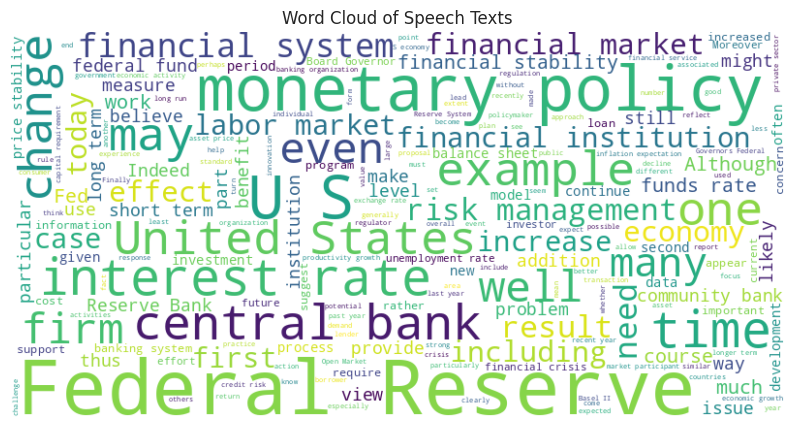

In [ ]:
# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Speech Texts')
plt.show()

<ipython-input-23-6edd8b79edcb>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Frequency', y='Word', data=common_words_df, palette="coolwarm")


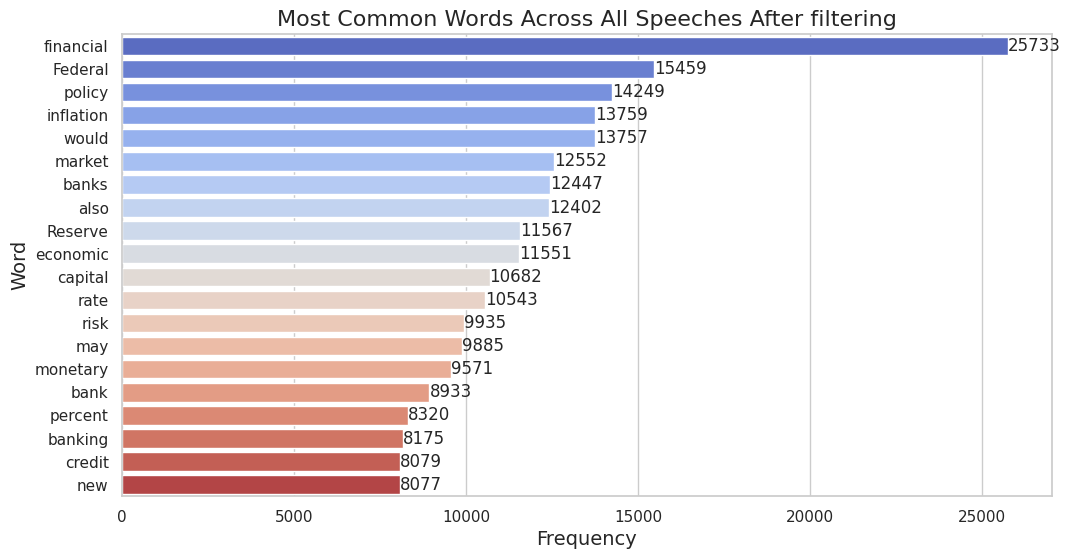

In [ ]:
word_counts = Counter(filtered_words.split())
common_words = word_counts.most_common(20)

# Convert to a DataFrame for easier plotting
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Set visual style
sns.set(style="whitegrid")

# Plot the bar chart
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Frequency', y='Word', data=common_words_df, palette="coolwarm")

# Add exact numbers to the end of each bar
for i, (freq, word) in enumerate(zip(common_words_df['Frequency'], common_words_df['Word'])):
    plt.text(freq + 2, i, str(freq), va='center', fontsize=12)

# Add titles and labels
plt.title('Most Common Words Across All Speeches After filtering', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)

# Display the plot
plt.show()

TODO: common words during recession periods

From this visualization, we aim to focus on specific key words and explore their surrounding context in greater depth. We can begin with terms such as 'financial,' 'policy,' 'inflation,' 'market,' and 'banks' to gain a clearer understanding of the context in which these words are used

TODO: below is a nice feature of co occurrence, we should use it but find better word combinations to look into.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Create a co-occurrence matrix for the keywords
keywords = ['financial', 'policy', 'inflation', 'market', 'banks']
vectorizer = CountVectorizer(vocabulary=keywords, binary=True)
X = vectorizer.fit_transform(df['speech_text'])
co_occurrence = (X.T * X).toarray()

# Convert to DataFrame for better visualization
co_matrix = pd.DataFrame(co_occurrence, index=keywords, columns=keywords)
print(co_matrix)


*TODO: make our own set or array of words we want to filter out.

# Clustering and Cluster Analysis

In [ ]:
# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])  # Remove punctuation and numbers
    words = [word for word in text.split() if word not in stop_words]  # Remove stop words
    return ' '.join(words)

df['speech_for_cluster'] = df['speech_text'].dropna().apply(preprocess_text)


In [ ]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features
# Filter out NaN values before applying fit_transform
X = vectorizer.fit_transform(df['speech_for_cluster'].dropna())


In [ ]:
# Get the top 20 words by TF-IDF scores
words = vectorizer.get_feature_names_out()
tfidf_scores = np.array(X.sum(axis=0)).flatten()
top_indices = tfidf_scores.argsort()[-20:][::-1]

top_words = [words[i] for i in top_indices]
top_scores = tfidf_scores[top_indices]

# Plot the top words
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_scores, color='skyblue')
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest TF-IDF score on top
plt.show()


In [ ]:
# Perform K-Means clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans on the TF-IDF matrix
kmeans.fit(X)

# Get cluster assignments for non-NaN rows
cluster_assignments = kmeans.labels_

# Create a new 'cluster' column and assign cluster labels to corresponding indices
df['cluster'] = pd.Series(cluster_assignments, index=df.index[df['speech_for_cluster'].notna()])

# Fill NaN values in 'cluster' column with -1 (or any other appropriate value)
df['cluster'].fillna(-1, inplace=True)

print("\nCluster assignments:")
print(df[['title', 'cluster']].head(10))

In [ ]:
# Analyze the clusters
for cluster in range(num_clusters):
    print(f"\nCluster {cluster} samples:")
    print(df[df['cluster'] == cluster]['title'].head(5))

In [ ]:
# Visualize cluster sizes
df['cluster'].value_counts().plot(kind='bar', title='Cluster Sizes', figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Number of Speeches')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'X' is your TF-IDF matrix and 'kmeans' is your fitted KMeans model
# If not, replace with the correct variables from your code

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())  # Convert sparse matrix to dense array

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    plt.scatter(X_pca[kmeans.labels_ == cluster, 0], X_pca[kmeans.labels_ == cluster, 1], label=f'Cluster {cluster}')
plt.title('Clusters in 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

silhouette score

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming 'X' is your TF-IDF matrix and 'kmeans' is your fitted KMeans model
# If not, replace with the correct variables from your code

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg}")

#Sentiment analysis

the challanges in this part are mostly our proccessing power avalabilty. the texts are long (avererage of 3000 words) and the models can run for so long. the approach we can take is using chunking to break the proccess down to fit finBert, or using BigBird which takes very long time to complete.

which will get us better results? finBert or BigBird?
If we go with finBert that is more suitable for financial language, what approach would work better? chunking and then averaging? maybe summarizing the text? focus on specific sentences with key words?

### create a 100 records sample

In [ ]:
import pandas as pd

# 100 count random sample to test different models
random_sample_df = df.sample(n=100, random_state=42)

# export and save for reuse
random_sample_df.to_csv("random_sample.csv", index=False)


In [ ]:
random_sample_df

In [ ]:
# prompt: load random_sample.csv into random_sample_df dataframe

import pandas as pd

random_sample_df = pd.read_csv('random_sample.csv')


## RNN

In [ ]:
speeches_market_data = pd.read_csv('speeches_for_LSTM.csv')

In [ ]:
speeches_market_data

,Unnamed: 0,id,speech_date,title,speaker,event,speech_text,role,speech_length,year,Date,Market_Sentiment,clean_text,sentiment_numeric
0,386,387,2003-12-02,Concerns and Considerations for the Practical ...,"Roger W. Ferguson, Jr.","At the ICBI Risk Management 2003 Conference, G...","Conference, Geneva, Switzerland \r\n\t\t\r\n ...",Vice Chairman,4580,2003,2003-12-02,Down,conference geneva switzerland december 2 2003 ...,NaN
1,385,386,2003-12-11,Capitalism and the role of globalization,Alan Greenspan,Before the World Affairs Council of Greater Da...,"Interest in issues of trade, tariffs, and prot...",Chairman,2891,2003,2003-12-11,Up,interest in issues of trade tariffs and protec...,NaN
2,547,548,2004-01-03,Conducting Monetary Policy at Very Low Short-T...,Ben S. Bernanke,At the International Center for Monetary and B...,Presented at the Meetings of the American Econ...,Governor,3927,2004,2004-01-02,Up,presented at the meetings of the american econ...,NaN
3,552,553,2004-01-03,Fedspeak,Ben S. Bernanke,At the Meetings of the American Economic Assoc...,Fedspeak\n\r\nThere was a time when central ba...,Governor,5671,2004,2004-01-02,Up,fedspeak there was a time when central bankers...,NaN
4,553,554,2004-01-03,Risk and Uncertainty in Monetary Policy,Alan Greenspan,At the Meetings of the American Economic Assoc...,Risk and Uncertainty in Monetary Policy\n\r\nT...,Chairman,5833,2004,2004-01-02,Up,risk and uncertainty in monetary policy this m...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,1694,1695,2024-11-20,Approaching Policymaking Pragmatically,Michelle W. Bowman,"At the Forum Club of the Palm Beaches, West Pa...",Good afternoon.1 It is a pleasure to join you ...,Governor,4310,2024,2024-11-20,Neutral,good afternoon 1 it is a pleasure to join you ...,1.0
1338,1693,1694,2024-11-22,Artificial Intelligence in the Financial System,Michelle W. Bowman,At the 27th Annual Symposium on Building the F...,Discussions of artificial intelligence (AI) in...,Governor,3406,2024,2024-11-22,Down,discussions of artificial intelligence ai inev...,NaN
1339,1692,1693,2024-12-02,Cut or Skip?,Christopher J. Waller,"At ""Building a Better Fed Framework,"" American...","Thank you, Lydia, and thank you for the opport...",Governor,2245,2024,2024-12-02,Up,thank you lydia and thank you for the opportun...,NaN
1340,1691,1692,2024-12-03,A Year in Review: A Tale of Two Supply Shocks,Adriana D. Kugler,"At the Detroit Economic Club, Detroit, Michigan","Thank you, Jason, and thank you for the opport...",Governor,2760,2024,2024-12-03,Up,thank you jason and thank you for the opportun...,NaN


In [ ]:
# Check if 'Market_Sentiment' column exists
if 'Market_Sentiment' not in speeches_market_data.columns:
    print("'Market_Sentiment' column not found in the DataFrame.")
else:
    # Create 'sentiment_numeric' column if it doesn't exist
    if 'sentiment_numeric' not in speeches_market_data.columns:
        speeches_market_data['sentiment_numeric'] = 0

    # Update 'sentiment_numeric' based on 'Market_Sentiment'
    speeches_market_data.loc[speeches_market_data['Market_Sentiment'] == 'Down', 'sentiment_numeric'] = 0
    speeches_market_data.loc[speeches_market_data['Market_Sentiment'] == 'Neutral', 'sentiment_numeric'] = 1
    speeches_market_data.loc[speeches_market_data['Market_Sentiment'] == 'Up', 'sentiment_numeric'] = 2

    # Print or inspect the modified DataFrame
    print(speeches_market_data.head()) # prints first 5 rows of the dataframe to check values


   Unnamed: 0   id speech_date  \
0         386  387  2003-12-02   
1         385  386  2003-12-11   
2         547  548  2004-01-03   
3         552  553  2004-01-03   
4         553  554  2004-01-03   

                                               title                 speaker  \
0  Concerns and Considerations for the Practical ...  Roger W. Ferguson, Jr.   
1           Capitalism and the role of globalization          Alan Greenspan   
2  Conducting Monetary Policy at Very Low Short-T...         Ben S. Bernanke   
3                                           Fedspeak         Ben S. Bernanke   
4            Risk and Uncertainty in Monetary Policy          Alan Greenspan   

                                               event  \
0  At the ICBI Risk Management 2003 Conference, G...   
1  Before the World Affairs Council of Greater Da...   
2  At the International Center for Monetary and B...   
3  At the Meetings of the American Economic Assoc...   
4  At the Meetings of the American

trying to use the above models was too costly, and not neccesarly fitting our metrics, these models might be trained to analyze financial jargon, but we are looking to build something more custom made to measure the influance of the federal reserve on difeerent markets and economic measures.

since we already know that computing power is precious, we will try to focus on the more significant part of our data rather than the whole thing, we will work around a number that covers most cases, and doesn't stretch our efforts to cover too short or too long speeches.

In [ ]:
max_sequence_length = int(np.percentile(speeches_market_data.speech_length, 95))
print(f"Selected max sequence length: {max_sequence_length}")

min_sequence_length = int(np.percentile(speeches_market_data.speech_length, 10))
print(f"Selected min sequence length: {min_sequence_length}")

Selected max sequence length: 5194
Selected min sequence length: 1030


we will build the RNN to be 5338 inputs, and we will also remove any speech bellow 1169. this approach will keep our work more precise and effiecient.

In [ ]:
from collections import Counter

all_words = ' '.join(speeches_market_data['speech_text'].dropna()).split()
vocab_size = len(set(all_words))

print(f"Vocabulary Size: {vocab_size}")


Vocabulary Size: 101956


this is a pretty huge vocabulary, let's take a look at the most common ones:

In [ ]:
word_counts = Counter(' '.join(speeches_market_data['speech_text'].dropna()).split())

print(word_counts.most_common(50))

[('the', 234659), ('of', 140932), ('to', 119641), ('and', 117798), ('in', 84370), ('a', 60891), ('that', 53470), ('for', 37449), ('is', 34547), ('on', 28004), ('as', 25774), ('have', 25267), ('are', 23769), ('be', 23455), ('with', 21088), ('by', 19810), ('The', 19561), ('financial', 19451), ('I', 18682), ('has', 15186), ('will', 14943), ('we', 14677), ('this', 14563), ('at', 14541), ('from', 14309), ('not', 14039), ('more', 13121), ('Federal', 12638), ('their', 12582), ('or', 12361), ('it', 11947), ('an', 11913), ('In', 11277), ('our', 11110), ('inflation', 11041), ('policy', 10700), ('these', 10439), ('would', 9602), ('Reserve', 9354), ('also', 9351), ('which', 9174), ('been', 9086), ('market', 9052), ('banks', 8979), ('about', 8894), ('can', 8882), ('some', 8866), ('economic', 8771), ('other', 8646), ('than', 8330)]


In [ ]:
all_words = ' '.join(speeches_market_data['speech_text'].dropna()).split()
stop_words = set(stopwords.words('english'))

unique_stop_words = set(word for word in all_words if word in stop_words)
num_unique_stop_words = len(unique_stop_words)
print(f"Number of unique stop words in the vocabulary: {num_unique_stop_words}")


Number of unique stop words in the vocabulary: 146


although many of the common words are 'stop_words' it is important to keep these to understand the context rather than to add context. additionaly 146 words out of around 45,000 planned to be included in the network is negligble.

bellow I will try to filter out very unique words in order to keep the vocabulary bellow 50,000 to fit out availble computing power.

In [ ]:
min_word_count = 3
filtered_vocab = {word: count for word, count in word_counts.items() if count >= min_word_count}
print(f"Filtered vocab size: {len(filtered_vocab)}")


Filtered vocab size: 35448


right around 36,000 seems like a fair number to go with, we will try to train the network and come back if the results are not good.

In [ ]:
def clean_text(text):
    text = text.lower()  # הופך לאותיות קטנות
    text = re.sub(r'\W+', ' ', text)  # מסיר סימני פיסוק
    words = text.split()  # מחלק למילים
    return ' '.join(words)  # מחבר את המילים חזרה לטקסט

# החלת הניקוי על כל הנתונים
speeches_market_data['clean_text'] = speeches_market_data['speech_text'].apply(clean_text)


save our work

In [ ]:
speeches_market_data.to_csv("speeches_for_LSTM.csv", index=False)

In [ ]:
# Count the number of speeches where speech_length is shorter than 1170
count = len(speeches_market_data[speeches_market_data['speech_length'] <= min_sequence_length])
count2 = len(speeches_market_data[speeches_market_data['speech_length'] >= max_sequence_length])
print(f"Number of speeches with speech_length shorter than 1030: {count}")
print(f"Number of speeches with speech_length longer than 5194: {count2}")
print((count+count2)/(speeches_market_data['id'].max()))

Number of speeches with speech_length shorter than 1030: 136
Number of speeches with speech_length longer than 5194: 68
0.11358574610244988


in order to keep our network more efficient again, we will focus our most significant records, avoiding using 'pad' tokens by removing some of the shorther speeches, as well as avoiding a very complex network by removing too long of speeches.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# קביעת מספר המילים המקסימלי
MAX_VOCAB_SIZE = 35488  # מספר המילים הייחודיות שנשמור
MAX_SEQUENCE_LENGTH = 5194  # אורך קלט אחיד לרשת

# טוקניזציה של הנתונים (שומר רק על 50,000 המילים הנפוצות ביותר)
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(speeches_market_data['clean_text'])

# המרת כל טקסט לרשימת טוקנים
sequences = tokenizer.texts_to_sequences(speeches_market_data['clean_text'])

# ריפוד/חיתוך לרשימות אחידות באורך 4096 טוקנים
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')



In [ ]:
print(MAX_SEQUENCE_LENGTH)
print(MAX_VOCAB_SIZE)

5194
35488


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# הגדרת המודל עם input_length
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=300, input_length=MAX_SEQUENCE_LENGTH),  # הוספת input_length
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# קומפילציה של המודל
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# הצגת מבנה המודל
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

# יצירת קלט פיקטיבי לבנייה נכונה
dummy_input = np.zeros((1, MAX_SEQUENCE_LENGTH))  # דוגמה בגודל המתאים

# בונה את המודל על סמך הקלט הפיקטיבי
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# הצגת מבנה המודל לאחר שהוא נבנה
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 5194, 300)           │      10,646,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 5194, 128)           │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 5194, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,917,635 (41.65 MB)

 Trainable params: 10,917,635 (41.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# הנחת יסוד: speeches_market_data['Market_Sentiment'] מכיל את התוויות (0=שלילי, 1=נייטרלי, 2=חיובי)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, speeches_market_data['sentiment_numeric'], test_size=0.2, random_state=42)

# הדפסת גדלי הקבוצות
print(f"✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


✅ X_train shape: (1073, 5194), y_train shape: (1073,)
✅ X_test shape: (269, 5194), y_test shape: (269,)


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 868s 25s/step - accuracy: 0.4542 - loss: 1.0618 - val_accuracy: 0.5167 - val_loss: 1.0320
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 865s 25s/step - accuracy: 0.5273 - loss: 1.0317 - val_accuracy: 0.5167 - val_loss: 1.0232
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 859s 25s/step - accuracy: 0.4858 - loss: 1.0433 - val_accuracy: 0.5167 - val_loss: 1.0190
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 917s 27s/step - accuracy: 0.5250 - loss: 1.0078 - val_accuracy: 0.5167 - val_loss: 1.0390
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 879s 25s/step - accuracy: 0.5141 - loss: 1.0013 - val_accuracy: 0.5167 - val_loss: 1.0692
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 903s 25s/step - accuracy: 0.5486 - loss: 0.9733 - val_accuracy: 0.5093 - val_loss: 1.1634
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 866s 25s/step - accuracy: 0.5159 - loss: 0.9933 - val_accuracy: 0.5167 - val_loss: 1.1358
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 861s 25s/step - accuracy: 0.5120 - loss: 0.9914 - val_accuracy: 0.

In [ ]:
# prompt: what do  i do with the output:
# Epoch 1/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 868s 25s/step - accuracy: 0.4542 - loss: 1.0618 - val_accuracy: 0.5167 - val_loss: 1.0320
# Epoch 2/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 865s 25s/step - accuracy: 0.5273 - loss: 1.0317 - val_accuracy: 0.5167 - val_loss: 1.0232
# Epoch 3/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 859s 25s/step - accuracy: 0.4858 - loss: 1.0433 - val_accuracy: 0.5167 - val_loss: 1.0190
# Epoch 4/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 917s 27s/step - accuracy: 0.5250 - loss: 1.0078 - val_accuracy: 0.5167 - val_loss: 1.0390
# Epoch 5/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 879s 25s/step - accuracy: 0.5141 - loss: 1.0013 - val_accuracy: 0.5167 - val_loss: 1.0692
# Epoch 6/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 903s 25s/step - accuracy: 0.5486 - loss: 0.9733 - val_accuracy: 0.5093 - val_loss: 1.1634
# Epoch 7/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 866s 25s/step - accuracy: 0.5159 - loss: 0.9933 - val_accuracy: 0.5167 - val_loss: 1.1358
# Epoch 8/10
# 34/34 ━━━━━━━━━━━━━━━━━━━━ 861s 25s/step - accuracy: 0.5120 - loss: 0.9914 - val_accuracy: 0.4981 - val_loss: 1.1470
# Epoch 9/10
#  6/34 ━━━━━━━━━━━━━━━━━━━━ 11:07 24s/step - accuracy: 0.4814 - loss: 1.0137

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
# ... (Your other imports)

# ... (Your data loading and preprocessing)

# Model with Early Stopping
model = Sequential([
    # ... (Your layers)
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Stop if validation loss doesn't improve for 3 epochs

history = model.fit(
    X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping]
)
